In [1]:
pip install regions

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pylab inline
import pandas as pd
from astropy.io import ascii, fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
import sys

Populating the interactive namespace from numpy and matplotlib


## Importing Gas Maps

In [3]:
comap = fits.open("ico.regrid.smooth.fits")
comapdata = comap[0].data[0,0]
#size (x,y) of the CO map data array
lencox, lencoy = comapdata.shape
#Filtering -- here we filter out n}ns and any value less than "thresh"
thresh = 0
mask = np.isnan(comapdata) | (comapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
comapdata[mask] = nan
#Get the world coordinates for the CO map
comapheader = comap[0].header
wc = wcs.WCS(comapheader, naxis=2)

In [4]:
atomicmap = fits.open("atomic_smoothed.fits")
atomicmapdata = atomicmap[0].data
#size (x,y) of the atomic map data array
lenatomicx, lenatomicy = atomicmapdata.shape
#Filtering -- here we filter out nans and any value less than "thresh"
thresh = 0
mask = np.isnan(atomicmapdata) | (atomicmapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
atomicmapdata[mask] = nan
#Get the world coordinates for the CO map
atomicmapheader = atomicmap[0].header
wc3 = wcs.WCS(atomicmapheader, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [5]:
acamaphdu = fits.open('NEW_ACA_MAP.fits')
acamapdata = acamaphdu[0].data
#size (x,y) of the CO map data array
lenacax, lenacay = acamapdata.shape
#Filtering -- here we filter out n}ns and any value less than "thresh"
thresh = 0
mask = np.isnan(acamapdata) | (acamapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
acamapdata[mask] = nan
#Get the world coordinates for the CO map
acamapheader = acamaphdu[0].header
wc4 = wcs.WCS(acamapheader, naxis=2)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
wrtab = ascii.read("wr_m33.tsv", data_start=3)
wrcoords = SkyCoord(wrtab["_RA"], wrtab["_DE"], unit="deg")
wrpix = np.asarray(skycoord_to_pixel(wrcoords, wc), dtype=int)
wrpix_insideco = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
wrco = comapdata[wrpix_insideco[1], wrpix_insideco[0]]
#Read ASCII table
rsgtab = ascii.read("rsg_m33.tsv", data_start=3)
#Get sky coordinates of RSGs
rsgcoords = SkyCoord(rsgtab["RAJ2000"], rsgtab["DEJ2000"], unit=("hourangle", "deg"))
#Convert sky coordinates to pixels using world coordinate system defined earlier
#np.asarray converts the list into a numpy array with data-type "int". Numpy arrays
#are much easier to manipulate than Python lists
rsgpix = np.asarray(skycoord_to_pixel(rsgcoords, wc), dtype=int)
#Only keep RSG pixels that fall inside the CO map area
#This line below uses the list comprehension trickery of Python! Its the equivalent of writing
rsgpix_insideco = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsgco = comapdata[rsgpix_insideco[1], rsgpix_insideco[0]]

In [7]:
#Read ASCII table
snrtab = ascii.read("snrs.tsv", data_start=3)
#Get sky coordinates of snrs
snrcoords = SkyCoord(snrtab["RAJ2000"], snrtab["DEJ2000"], unit=("hourangle", "deg"))
#Convert sky coordinates to pixels using world coordinate system defined earlier
#np.asarray converts the list into a numpy array with data-type "int". Numpy arrays
#are much easier to manipulate than Python lists
snrpix = np.asarray(skycoord_to_pixel(snrcoords, wc), dtype=int)
#Only keep SNR pixels that fall inside the CO map area
#This line below uses the list comprehension trickery of Python! Its the equivalent of writing
snrpix_insideco = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

#Get CO intensity values for the SNR pixels
snrco = comapdata[snrpix_insideco[1], snrpix_insideco[0]]

## Region

In [8]:
from regions import Regions
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion, PixCoord, CirclePixelRegion
from regions import PixCoord

sky_region = Regions.read('ACAregion_new2.reg', format='ds9')
rsg_skycoords = np.transpose(rsgcoords)
rsg_skycoords2 = np.transpose(rsgcoords)
wr_skycoords = np.transpose(wrcoords)
snr_skycoords = np.transpose(snrcoords)

In [9]:
from regions import RectangleSkyRegion, RectanglePixelRegion
from astropy import units as u
center_sky = SkyCoord(23.4752025, 30.6131352, unit='deg', frame='fk5')
region = RectangleSkyRegion(center=center_sky, width=778.045*u.arcsec, height=885.116*u.arcsec, angle=13.715856*u.deg)
pixel_region = region.to_pixel(wc3)

center_sky2 = SkyCoord(23.5353598, 30.7876893, unit='deg', frame='fk5')
region2 = RectangleSkyRegion(center=center_sky2, width=783.85*u.arcsec, height=421.569*u.arcsec, angle=13.7*u.deg)
pixel_region2 = region2.to_pixel(wc3)

In [10]:
atomicpixel_region = region.to_pixel(wc3)
atomicpixel_region2 = region2.to_pixel(wc3)

## Getting Stars in Region

In [11]:
#Getting our new stellar populations; RSGs
arr_is_inside1 = sky_region[0].contains(rsg_skycoords, wc4)
rsgs_inside_box1 = rsg_skycoords[arr_is_inside1]
arr_is_inside2 = sky_region[1].contains(rsg_skycoords2, wc4)
rsgs_inside_box2 = rsg_skycoords2[arr_is_inside2]

#WR
arr_is_inside3 = sky_region[0].contains(wr_skycoords, wc4)
wrs_inside_box1 = wr_skycoords[arr_is_inside3]
arr_is_inside4 = sky_region[1].contains(wr_skycoords, wc4)
wrs_inside_box2 = wr_skycoords[arr_is_inside4]

#SNRs
arr_is_inside5 = sky_region[0].contains(snr_skycoords, wc4)
snr_inside_box1 = snr_skycoords[arr_is_inside5]
arr_is_inside6 = sky_region[1].contains(snr_skycoords, wc4)
snr_inside_box2 = snr_skycoords[arr_is_inside6]

In [12]:
# Getting pixels of stars on the aca map
rsgpix2_aca = np.asarray(skycoord_to_pixel(rsgs_inside_box1, wc4), dtype=int)
rsgpix3_aca = np.asarray(skycoord_to_pixel(rsgs_inside_box2, wc4), dtype=int)
rsgpix_inside_aca = np.concatenate((rsgpix2_aca, rsgpix3_aca), axis=1)
rsgpix_inside_inaca = np.array([[i,j] for i,j in rsgpix_inside_aca.T if ((0<=j<lenacax) and (0<=i<lenacay))]).T
rsg_inaca = acamapdata[rsgpix_inside_inaca[1], rsgpix_inside_inaca[0]]
#rsgpix_insideco = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

wrpix2_aca = np.asarray(skycoord_to_pixel(wrs_inside_box1, wc4), dtype=int)
wrpix3_aca = np.asarray(skycoord_to_pixel(wrs_inside_box2, wc4), dtype=int)
wrpix_inside_aca = np.concatenate((wrpix2_aca, wrpix3_aca), axis=1)
wrpix_inside_inaca = np.array([[i,j] for i,j in wrpix_inside_aca.T if ((0<=j<lenacax) and (0<=i<lenacay))]).T
wr_inaca = acamapdata[wrpix_inside_inaca[1], wrpix_inside_inaca[0]]


snrpix2_aca = np.asarray(skycoord_to_pixel(snr_inside_box1, wc4), dtype=int)
snrpix3_aca = np.asarray(skycoord_to_pixel(snr_inside_box2, wc4), dtype=int)
snrpix_inside_aca = np.concatenate((snrpix2_aca, snrpix3_aca), axis=1)
snrpix_inside_inaca = np.array([[i,j] for i,j in snrpix_inside_aca.T if ((0<=j<lenacax) and (0<=i<lenacay))]).T
snr_inaca = acamapdata[snrpix_inside_inaca[1], snrpix_inside_inaca[0]]

In [13]:
rsgpix2 = np.asarray(skycoord_to_pixel(rsgs_inside_box1, wc), dtype=int)
rsgpix3 = np.asarray(skycoord_to_pixel(rsgs_inside_box2, wc), dtype=int)
rsgpix_inside = np.concatenate((rsgpix2, rsgpix3), axis=1)
rsgpix_inside_inco = np.array([[i,j] for i,j in rsgpix_inside.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsg_inco = comapdata[rsgpix_inside_inco[1], rsgpix_inside_inco[0]]


wrpix2 = np.asarray(skycoord_to_pixel(wrs_inside_box1, wc), dtype=int)
wrpix3 = np.asarray(skycoord_to_pixel(wrs_inside_box2, wc), dtype=int)
wrpix_inside = np.concatenate((wrpix2, wrpix3), axis=1)
wrpix_inside_inco = np.array([[i,j] for i,j in wrpix_inside.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
wr_inco = comapdata[wrpix_inside_inco[1], wrpix_inside_inco[0]]


snrpix2 = np.asarray(skycoord_to_pixel(snr_inside_box1, wc), dtype=int)
snrpix3 = np.asarray(skycoord_to_pixel(snr_inside_box2, wc), dtype=int)
snrpix_inside = np.concatenate((snrpix2, snrpix3), axis=1)
snrpix_inside_inco = np.array([[i,j] for i,j in snrpix_inside.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
snr_inco = comapdata[snrpix_inside_inco[1], snrpix_inside_inco[0]]

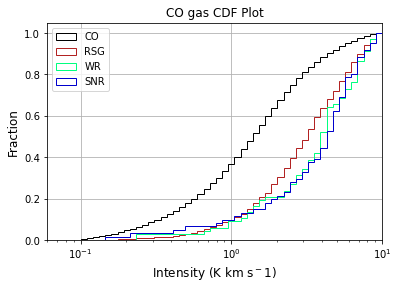

In [14]:
plt.figure()
plt.hist(comapdata.flatten(), histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="CO")
plt.hist(rsg_inco, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="RSG")
plt.hist(wr_inco, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="WR")
plt.hist(snr_inco, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="SNR")
plt.title('CO Map CDF')
plt.xlabel("Intensity (K km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.06, 10)
plt.legend(loc=2)
plt.title('CO gas CDF Plot')
plt.grid()
plt.show()

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(550.0, 1070.0)

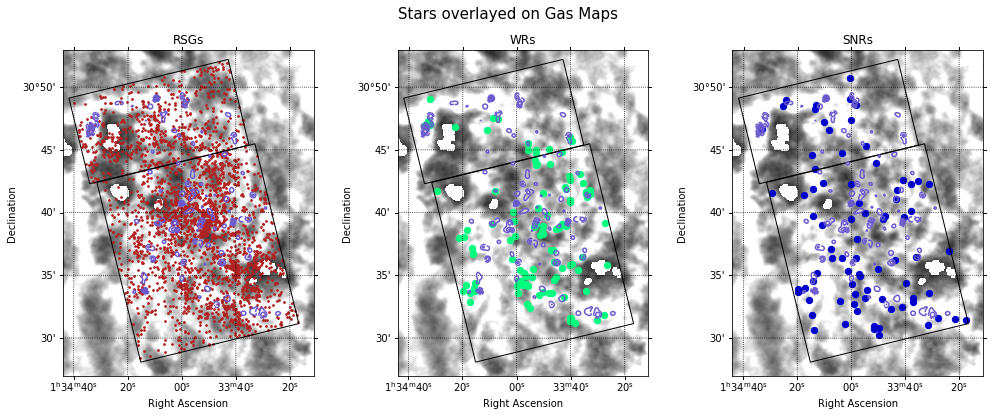

In [17]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from regions import PixCoord, CirclePixelRegion
import matplotlib.pyplot as plt
import sympy
from sympy import init_printing
conv = (1.82*10**18 * math.cos(55.1*3.14 / 180)) # Km s^-1 to cm^-2
filename = get_pkg_data_filename('atomic.fits')
hdu = fits.open(filename)[0]
conv_hdu = conv * hdu.data

##RSG
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(17,6))
ax = plt.subplot(131, projection=wc3, label='overlays')
plt.suptitle('Stars overlayed on Gas Maps', fontsize = 15)

ax.imshow(conv_hdu, cmap='gray',  vmin=-100 * conv, vmax= 560 * conv)
#cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
#cbar.set_label('Column Density (cm$^-2$)', rotation=90)
#cbar.ax.set_title('10^21')
ax.set_title('RSGs')

ax.coords.grid(True, color='black', ls='dotted')
ax.coords[0].set_axislabel('Right Ascension')
ax.coords[1].set_axislabel('Declination')
              
#Stars
ax.scatter(rsgs_inside_box2.ra.deg, rsgs_inside_box2.dec.deg, transform=ax.get_transform('fk5'),  s=3, edgecolor='firebrick', facecolor='firebrick', cmap='gray', label= 'RSGs', color='firebrick')
ax.scatter(rsgs_inside_box1.ra.deg, rsgs_inside_box1.dec.deg, transform=ax.get_transform('fk5'), s=3, edgecolor='firebrick', facecolor='firebrick', cmap='gray')
atomicpixel_region.plot()
atomicpixel_region2.plot()
ax.contour(acamapdata, transform=ax.get_transform(WCS(acamapheader, naxis=2)), colors='slateblue')
#location = 0 # For the best location
#legend_drawn_flag = True
#axs[1].legend()
ax.set_xlim(400,800)   
ax.set_ylim(550,1070)

## WR
ax2 = plt.subplot(132, projection=wc3, label='overlays')
ax2.imshow(conv_hdu, cmap='gray',  vmin=-100 * conv, vmax= 560 * conv)
#cbar = plt.colorbar()
#cbar.ax.set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
#cbar.axs[0].set_label('Column Density (cm$^-2$)', rotation=90)
#cbar.ax.set_title('10^21')
ax2.set_title('WRs')

ax2.coords.grid(True, color='black', ls='dotted')
ax2.coords[0].set_axislabel('Right Ascension')
ax2.coords[1].set_axislabel('Declination')
              
#Stars
ax2.scatter(wrs_inside_box2.ra.deg, wrs_inside_box2.dec.deg, transform=ax2.get_transform('fk5'),  s=40, edgecolor='springgreen', facecolor='springgreen', cmap='gray', label= 'WRs', color='springgreen')
ax2.scatter(wrs_inside_box1.ra.deg, wrs_inside_box1.dec.deg, transform=ax2.get_transform('fk5'), s=40, edgecolor='springgreen', facecolor='springgreen', cmap='gray')
atomicpixel_region.plot()
atomicpixel_region2.plot()
ax2.contour(acamapdata, transform=ax2.get_transform(WCS(acamapheader, naxis=2)), colors='slateblue')
#location = 0 # For the best location
#legend_drawn_flag = True
#axs[1].legend()
ax2.set_xlim(400,800)   
ax2.set_ylim(550,1070)

ax3 = plt.subplot(133, projection=wc3, label='overlays')
ax3.imshow(conv_hdu, cmap='gray',  vmin=-100 * conv, vmax= 560 * conv)
#cbar = plt.colorbar()
#cbar.axs[0].set_yticklabels(['0','0.5','1','1.5', '2.0', '2.5', '3.0'])
#cbar.axs[0].set_label('Column Density (cm$^-2$)', rotation=90)
#cbar.ax.set_title('10^21')
ax3.set_title('SNRs')

ax3.coords.grid(True, color='black', ls='dotted')
ax3.coords[0].set_axislabel('Right Ascension')
ax3.coords[1].set_axislabel('Declination')
              
#Stars
ax3.scatter(snr_inside_box2.ra.deg, snr_inside_box2.dec.deg, transform=ax3.get_transform('fk5'),  s=40, edgecolor='mediumblue', facecolor='mediumblue', cmap='gray', label= 'SNRs', color='mediumblue')
ax3.scatter(snr_inside_box1.ra.deg, snr_inside_box1.dec.deg, transform=ax3.get_transform('fk5'), s=40, edgecolor='mediumblue', facecolor='mediumblue', cmap='gray')
atomicpixel_region.plot()
atomicpixel_region2.plot()
ax3.contour(acamapdata, transform=ax3.get_transform(WCS(acamapheader, naxis=2)), colors='slateblue')
#location = 0 # For the best location
#legend_drawn_flag = True
#axs[1].legend()
ax3.set_xlim(400,800)   
ax3.set_ylim(550,1070)

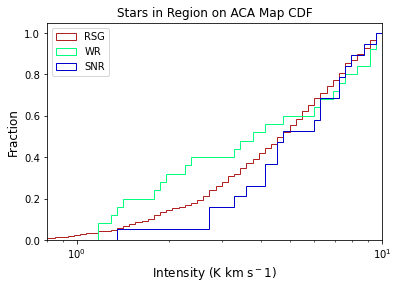

In [16]:
plt.figure()
#plt.hist(comapdata.flatten(), histtype="step", color="k", \
         #density=True, cumulative=True, bins=np.logspace(-1, 1, 100), label="CO")
plt.hist(rsg_inaca, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 100), label="RSG")
plt.hist(wr_inaca, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 100), label="WR")
plt.hist(snr_inaca, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 100), label="SNR")
plt.title('Stars in Region on ACA Map CDF')
plt.xlabel("Intensity (K km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.8, 10)
plt.legend(loc=2)
plt.show()

In [ ]:
def get_ncr(data, vals):
    """
    Sets nans equal to 0 in both arrays and returns
    the ncr value
    """
    a = np.nan_to_num(data, copy=True, nan=0.0)
    b = np.nan_to_num(vals, copy=True, nan=0.0)
    a2 = np.sort(a)
    return np.array([np.where(a2>=x)[0][0]/len(a2) for x in b])

In [ ]:
comap_zeronans = np.nan_to_num(comapdata.flatten(), copy=True, nan=0.0)
sorted_comap_zeronans = np.sort(comap_zeronans)

filter_arr = []

for element in sorted_comap_zeronans:

  if element > 0:
    filter_arr.append(True)
  else:
    filter_arr.append(False)
    
sorted_comap_nozeros = sorted_comap_zeronans[filter_arr]

In [ ]:
snrco2 = np.sort(np.nan_to_num(snrco, copy=True, nan=0.0))
ncr_snrco = get_ncr(sorted_comap_nozeros, snrco)
ncr_WR = get_ncr(sorted_comap_nozeros, wrco)
ncr_RSG = get_ncr(sorted_comap_nozeros, rsgco)

In [ ]:
#Ness CO Data
ncr_type1a = np.array([0, 0, 0, 0, 0, 0, 0, 0.05, 0.65, 0.73, 0.83, 0.89])
ncr_type2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05, 0.1, 0.1, 0.18, 0.29, 0.37, 0.41, 0.68, 0.7, 0.72, 0.76, 0.81, 0.83, 0.9, 0.93, 0.98, 0.98, 0.99, 1])
ncr_sesn = np.array([0, 0.2, 0.24, 0.75, 0.92, 0.95, 0.98, 1])
ncr_unclassified = np.array([0, 0.56, 0.91, 0.92, 0.96, 0.99, 0.99])
ncr_all = np.sort(np.concatenate((ncr_type1a, ncr_type2, ncr_sesn, ncr_unclassified)))

In [ ]:
plt.figure()
plt.hist(ncr_RSG, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.hist(ncr_WR, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_snrco, histtype="step", color="goldenrod", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
plt.hist(ncr_type1a, histtype="step", color="cyan", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="Type 1a")
plt.hist(ncr_type2, histtype="step", color="orange", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="Type 2")
plt.hist(ncr_sesn, histtype="step", color="magenta", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SESN")
plt.hist(ncr_unclassified, histtype="step", color="yellow", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="Unclassified")


plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2, prop={'size': 7})
plt.show()

plt.figure()
plt.hist(comapdata.flatten(), histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="CO")
plt.hist(rsgco, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="RSG")
plt.hist(wrco, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="WR")
plt.hist(snrco, histtype="step", color="goldenrod", \
         density=True, cumulative=True, bins=np.logspace(-1, 1, 50), label="SNR")
plt.title('CO Map CDF')
plt.xlabel("Intensity (km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(0.06, 10)
plt.legend(loc=2)
plt.title('CO gas CDF Plot')
plt.show()

In [ ]:
atomicmap_zeronans = np.nan_to_num(atomicmapdata.flatten(), copy=True, nan=0.0)
sorted_atomicmap_zeronans = np.sort(atomicmap_zeronans)

filter_arr2 = []

for element in sorted_atomicmap_zeronans:

  if element > 0:
    filter_arr2.append(True)
  else:
    filter_arr2.append(False)
    
sorted_atomicmap_nozeros = sorted_atomicmap_zeronans[filter_arr2]

In [ ]:
wrpix_insideatomic = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsgpix_insideatomic = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
snrpix_insideatomic = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

wratomic = atomicmapdata[wrpix_insideatomic[1], wrpix_insideatomic[0]]
rsgatomic = atomicmapdata[rsgpix_insideatomic[1], rsgpix_insideatomic[0]]
snratomic = atomicmapdata[snrpix_insideatomic[1], snrpix_insideatomic[0]]

#Getting NCR
ncr_WRatomic = get_ncr(sorted_atomicmap_nozeros, wratomic)
ncr_RSGatomic = get_ncr(sorted_atomicmap_nozeros, rsgatomic)
ncr_snratomic = get_ncr(sorted_atomicmap_nozeros, snratomic)

In [ ]:
plt.figure()
plt.hist(ncr_RSGatomic, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs")
plt.hist(ncr_WRatomic, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRs")
plt.hist(ncr_snratomic, histtype="step", color="goldenrod", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="SNRs")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('Atomic gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

plt.figure()
plt.hist(sorted_atomicmap_nozeros, histtype="step", color="k", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="Atomic")
plt.hist(rsgatomic, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="RSGs")
plt.hist(wratomic, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="WRs")
plt.hist(snratomic, histtype="step", color="goldenrod", \
         density=True, cumulative=True, bins=np.logspace(0, 4, 1000), label="SNRs")
plt.title('Atomic Map CDF')
plt.xlabel("Intensity (km s$^-1$)", fontsize=12)
plt.ylabel("Fraction", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=2)
plt.show()

## FIGURE 4 and 5            Histograms With Fraction of HI 

In [ ]:
conv = (1.82*10**18 * math.cos(55.1*3.14 / 180)) # Km s^-1 to cm^-2
conv_CO = ((4*10**20) / 0.8) * math.cos(55.1*3.14 / 180)
co_dense = comapdata * conv_CO
fraction_HI = (atomicmapdata * conv) / ((atomicmapdata * conv) + co_dense)
lenatomic2x, lenatomic2y = fraction_HI.shape
#Filtering -- here we filter out nans and any value less than "thresh"
thresh = 0
mask = np.isnan(fraction_HI) | (fraction_HI<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
fraction_HI[mask] = nan


In [ ]:
aca_dense = acamapdata * conv_CO
fraction_HI_aca = (atomicmapdata * conv) / ((atomicmapdata * conv) + aca_dense)
lenatomic3x, lenatomic3y = fraction_HI_aca.shape
#Filtering -- here we filter out nans and any value less than "thresh"
thresh = 0
mask = np.isnan(fraction_HI_aca) | (fraction_HI_aca<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
fraction_HI_aca[mask] = nan

In [ ]:
rsgpix_insideatomic2 = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lenatomic2x) and (0<=i<lenatomic2y))]).T
wrpix_insideatomic2 = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lenatomic2x) and (0<=i<lenatomic2y))]).T
snrpix_insideatomic2 = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lenatomic2x) and (0<=i<lenatomic2y))]).T

#ACA
rsgpix_insideatomic3 = np.array([[i,j] for i,j in rsgpix.T if ((0<=j<lenatomic3x) and (0<=i<lenatomic3y))]).T
wrpix_insideatomic3 = np.array([[i,j] for i,j in wrpix.T if ((0<=j<lenatomic3x) and (0<=i<lenatomic3y))]).T
snrpix_insideatomic3 = np.array([[i,j] for i,j in snrpix.T if ((0<=j<lenatomic3x) and (0<=i<lenatomic3y))]).T

rsgatomic2 = fraction_HI[rsgpix_insideatomic2[1], rsgpix_insideatomic2[0]]
wratomic2 = fraction_HI[wrpix_insideatomic2[1], wrpix_insideatomic2[0]]
snratomic2 = fraction_HI[snrpix_insideatomic2[1], snrpix_insideatomic2[0]]

#ACA
rsgatomic3 = fraction_HI_aca[rsgpix_insideatomic3[1], rsgpix_insideatomic3[0]]
wratomic3 = fraction_HI_aca[wrpix_insideatomic3[1], wrpix_insideatomic3[0]]
snratomic3 = fraction_HI_aca[snrpix_insideatomic3[1], snrpix_insideatomic3[0]]

#With stars in region
#rsgatomic_fraction = fraction_HI[rsgpix_insideatomic2[1], rsgpix_insideatomic2[0]]
#wratomic_fraction = fraction_HI[wrpix_insideatomic2[1], wrpix_insideatomic2[0]]
#snratomic_fraction = fraction_HI[snrpix_insideatomic2[1], snrpix_insideatomic2[0]]


conv = (1.82*10**18 * math.cos(55.1*3.14 / 180)) # Km s^-1 to cm^-2
conv_CO = (4*10**20) / 0.8 * math.cos(55.1*3.14 / 180)
atomic2_dense = conv * fraction_HI
rsg_atomic2dense = conv * rsgatomic2
wr_atomic2dense = conv * wratomic2
snr_atomic2dense = conv * snratomic2

rsg_atomic3dense = conv * rsgatomic3
wr_atomic3dense = conv * wratomic3
snr_atomic3dense = conv * snratomic3

In [ ]:
plt.hist(fraction_HI.flatten(), bins=np.logspace(-1,0,100), alpha=0.5)
#plt.xscale('log')
plt.xlabel('Fraction')
plt.ylabel('Number of Pixels')
plt.title('Atomic Pixels on Atomic Fraction Map')
#plt.xlim(0, 0.99)

In [ ]:
plt.hist(rsg_atomic2dense, bins=np.logspace(16,19,100), alpha=0.5,  color = 'firebrick')
#plt.hist(wr_atomic2dense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'springgreen')
#plt.hist(snr_atomic2dense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'goldenrod')
plt.xscale('log')
plt.xlabel('Fraction')
plt.ylabel('Number of Pixels')
plt.title('RSG Pixels on Atomic Fraction Map')

In [ ]:
#plt.hist(rsg_atomic2dense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'firebrick')
plt.hist(wr_atomic2dense, bins=np.logspace(16,19,75), alpha=0.5,  color = 'springgreen')
#plt.hist(snr_atomic2dense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'goldenrod')
plt.xscale('log')
plt.xlabel('Fraction')
plt.ylabel('Number of Pixels')
plt.title('WR Pixels on Atomic Fraction Map')

In [ ]:
#plt.hist(rsg_atomic2dense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'firebrick')
#plt.hist(wr_atomic2dense, bins=np.logspace(19,22,100), alpha=0.5,  color = 'springgreen')
plt.hist(snr_atomic2dense, bins=np.logspace(16,19,40), alpha=0.5,  color = 'mediumblue')
plt.xscale('log')
plt.xlabel('Fraction')
plt.ylabel('Number of Pixels')
plt.title('SNR Pixels on Atomic Fraction Map')

In [ ]:
atomicmap2_zeronans = np.nan_to_num(fraction_HI.flatten(), copy=True, nan=0.0)
sorted_atomicmap2_zeronans = np.sort(atomicmap2_zeronans)
filter_arr2 = []

for element in sorted_atomicmap2_zeronans:

  if element > 0:
    filter_arr2.append(True)
  else:
    filter_arr2.append(False)
    
sorted_atomicmap2_nozeros = sorted_atomicmap2_zeronans[filter_arr2]

In [ ]:
print(sorted_atomicmap2_nozeros)

In [ ]:
plt.figure()
#plt.hist(sorted_atomicmap2_nozeros, histtype="step", color="k", \
         #density=True, cumulative=True, bins=np.logspace(-1,0, 1000), label="Atomic")
plt.hist(rsgatomic2, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 0, 1000), label="RSGs")
plt.hist(wratomic2, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 0, 1000), label="WRs")
plt.hist(snratomic2, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(-1, 0, 1000), label="SNRs")
plt.title('Druard Atomic Fraction CDF')
plt.xlabel('Atomic Fraction', fontsize=12)
plt.ylabel("Fraction of Sample < Given Atomic Fraction ", fontsize=12)
#plt.xscale("log")
#plt.xlim(10**-1, 1)
plt.legend(loc=2)
plt.grid(ls = 'dashed')
plt.show()

In [ ]:
plt.figure()
#plt.hist(sorted_atomicmap2_nozeros, histtype="step", color="k", \
         #density=True, cumulative=True, bins=np.logspace(-1,0, 1000), label="Atomic")
plt.hist(rsgatomic3, histtype="step", color="firebrick", \
         density=True, cumulative=True, bins=np.logspace(-1, 0, 1000), label="RSGs")
plt.hist(wratomic3, histtype="step", color="springgreen", \
         density=True, cumulative=True, bins=np.logspace(-1, 0, 1000), label="WRs")
plt.hist(snratomic3, histtype="step", color="mediumblue", \
         density=True, cumulative=True, bins=np.logspace(-1, 0, 1000), label="SNRs")
plt.title('ACA Atomic Fraction CDF')
plt.xlabel("Atomic Fraction", fontsize=12)
plt.ylabel("Fraction of Sample < Given Atomic Fraction ", fontsize=12)
#plt.xscale("log")
#plt.xlim(10**-1, 1)
plt.legend(loc=2)
plt.grid(ls = 'dashed')
plt.show()

In [ ]:
rsgpix_insideatomic2_aca = np.array([[i,j] for i,j in rsg_inaca.T if ((0<=j<lenatomic3x) and (0<=i<lenatomic3y))]).T
wrpix_insideatomic2_aca = np.array([[i,j] for i,j in wr_inaca.T if ((0<=j<lenatomic3x) and (0<=i<lenatomic3y))]).T
snrpix_insideatomic2_aca = np.array([[i,j] for i,j in snr_inaca.T if ((0<=j<lenatomic3x) and (0<=i<lenatomic3y))]).T

rsgatomic3 = fraction_HI_aca[rsgpix_insideatomic2_aca[1], rsgpix_insideatomic2_aca[0]]
wratomic3 = fraction_HI_aca[wrpix_insideatomic2_aca[1], wrpix_insideatomic2_aca[0]]
snratomic3 = fraction_HI_aca[snrpix_insideatomic2_aca[1], snrpix_insideatomic2_aca[0]]

## Testing

In [ ]:
from regions import RectangleSkyRegion, RectanglePixelRegion
from astropy import units as u
center_sky = SkyCoord(23.4752025, 30.6131352, unit='deg', frame='fk5')
region = RectangleSkyRegion(center=center_sky, width=778.045*u.arcsec, height=885.116*u.arcsec, angle=13.715856*u.deg)
pixel_region = region.to_pixel(wc2)

center_sky2 = SkyCoord(23.5353598, 30.7876893, unit='deg', frame='fk5')
region2 = RectangleSkyRegion(center=center_sky2, width=783.85*u.arcsec, height=421.569*u.arcsec, angle=13.7*u.deg)
pixel_region2 = region2.to_pixel(wc2)

pixel_regionCO = region.to_pixel(wc)
pixel_regionCO2 = region2.to_pixel(wc)